In [2]:
import time
import requests
import urllib.parse
import hashlib
import hmac
import base64
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
api_url = "https://api.kraken.com"
api_key = ""
api_sec = ""


def get_kraken_signature(urlpath, data, secret):
    postdata = urllib.parse.urlencode(data)
    encoded = (str(data['nonce']) + postdata).encode()
    message = urlpath.encode() + hashlib.sha256(encoded).digest()

    mac = hmac.new(base64.b64decode(secret), message, hashlib.sha512)
    sigdigest = base64.b64encode(mac.digest())
    return sigdigest.decode()


def kraken_request(url_path, data, api_key, api_sec):
    headers = {"API-Key": api_key, "API-Sign": get_kraken_signature(url_path, data, api_sec)}
    resp = requests.post((api_url + url_path), headers=headers, data=data)
    return resp


def get_info(domain, params):
    resp = kraken_request(("/0/private/" + domain), params, api_key, api_sec)
    return resp.json()


def get_public_info(domain, params):
    resp = kraken_request(("/0/public/" + domain), params, api_key, api_sec)
    return resp.json()


def read_command(c, interval):
    params = {
        "nonce": str(int(1000 * time.time()))
    }
    if c == "Balance":
        values = get_info("Balance", params)['result']
        for coin in values:
            if float(values[coin]) > 0:
                print(coin + "  -  " + values[coin])
    elif c == "TradeBalance":
        values = get_info(c,params)['result']
        print(values)
    elif c == "OpenOrders":
        values = get_info(c,params)['result']
        descrs = []
        for value in values['open']:
            print(values['open'][value]['descr'])
            descrs.append(values['open'][value]['descr'])
        return descrs
    elif c == "AssetInfo":
        queryDomains = []
        for coin in InterestAssets:
            queryDomains.append("OHLC?pair=" + coin + "USD")
            
        OHLCvals = {}
        
        params['asset'] = InterestAssets
        #
        #
        #Setting interval
        #
        #
        params['interval'] = interval
        for coin in InterestAssets:
            chubby = get_public_info(("OHLC?pair=" + coin + "USD"), params)
            OHLCvals[coin] = chubby['result']
            
        return OHLCvals


In [4]:
#Specify the command and the assets of interest, they will be passed globally
c = "OpenOrders"
InterestAssets = ["XBT", "ETH"]

In [5]:
AssetInfo = "AssetInfo"
#1MinuteData
FiveMinuteData = read_command(AssetInfo, 5)
fiveMinuteData = pd.DataFrame(FiveMinuteData["XBT"]["XXBTZUSD"])
fiveMinuteData.columns = ["Time","Open","High","Low","Close","Valued_Price","Volume","Count"]
fiveMinuteData = fiveMinuteData.drop("Time", axis = 1)
#15MinutesData
FifteenMinuteData = read_command(AssetInfo, 15)
fifteenMinuteData = pd.DataFrame(FifteenMinuteData["XBT"]["XXBTZUSD"])
fifteenMinuteData.columns = ["Time","Open","High","Low","Close","Valued_Price","Volume","Count"]
fifteenMinuteData = fifteenMinuteData.drop("Time", axis=1)
#HourlyData
OneHourData = read_command(AssetInfo, 60)
oneHourData = pd.DataFrame(OneHourData["XBT"]["XXBTZUSD"])
oneHourData.columns = ["Time","Open","High","Low","Close","Valued_Price","Volume","Count"]
oneHourData = oneHourData.drop("Time", axis=1)
#4HourData
FourHourData = read_command(AssetInfo, 240)
fourHourData = pd.DataFrame(FourHourData["XBT"]["XXBTZUSD"])
fourHourData.columns = ["Time","Open","High","Low","Close","Valued_Price","Volume","Count"]
fourHourData = fourHourData.drop("Time", axis=1)
#1DayData
OneDayData = read_command(AssetInfo, 1440)
oneDayData = pd.DataFrame(OneDayData["XBT"]["XXBTZUSD"])
oneDayData.columns = ["Time","Open","High","Low","Close","Valued_Price","Volume","Count"]
oneDayData = oneDayData.drop("Time", axis=1)
#HalfYearData
halfYearData = oneDayData.iloc[(719-180):719, :]
halfYearData = halfYearData.reset_index()
halfYearData = halfYearData.drop(["index"], axis = 1)
#OneYearData
oneYearData = oneDayData.iloc[(719-360):719, :]
oneYearData = oneYearData.reset_index()
oneYearData = oneYearData.drop(["index"], axis = 1)
#OneMonthData
oneMonthData = oneDayData.iloc[(719-30):719, :]
oneMonthData = oneMonthData.reset_index()
oneMonthData = oneMonthData.drop(['index'], axis = 1)
#ThreeMonthData
threeMonthData = oneDayData.iloc[(719-90):719,:]
threeMonthData = threeMonthData.reset_index()
threeMonthData = threeMonthData.drop(["index"], axis = 1)

In [151]:
#Calculate MAs
def calculate_ma(scale):
    #One day in five minute increments
    if (scale == 1):
        info = fifteenMinuteData.iloc[(720-288):720,:]

    
    elif (scale == 3):
        info = oneHourData.iloc[(720-72):720,:]
    
        
    elif (scale == 7):
        info = oneHourData.iloc[(720-168):720,:]

        
    elif (scale == 14):
        info = oneHourData.iloc[(720-336):720,:]

    
    elif (scale == 30):
        info = oneHourData

        
        
    elif (scale == 60):    
        info = fourHourData.iloc[(720-360):720,:]

        
    elif (scale == 90):
        info = fourHourData.iloc[(720-540):720,:]

        
    elif (scale == 180):
        info = oneDayData.iloc[(720-180):720,:]
        
    else:
        print("No such parameter")

    #calculations
    num = 0
    ma = 0.0
    mas = []
    for value in info["Valued_Price"]:
        ma = ma * num
        num = num + 1
        ma = ma + int(np.ceil(float(value)))
        #print(np.ceil(float(ma)))
        ma = np.ceil(ma/num)
        mas.append(ma)
    return info, mas
            
def dropExtras(info):
    transInfo = info.drop(columns=["High", 'Low', 'Open', "Close", 'Volume', "Count"])
    transInfo = transInfo.reset_index()
    transInfo = transInfo.drop(columns="index")
    return transInfo



#Control Variable
period = 1

<AxesSubplot:>

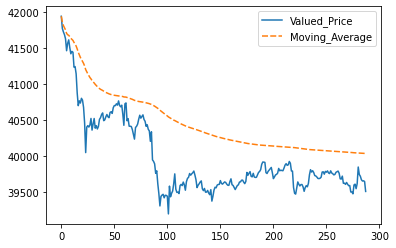

In [152]:
dat = pd.DataFrame(calculate_ma(period)[1])
info = calculate_ma(period)[0]
transInfo = dropExtras(info)
data = pd.concat([dat, transInfo], axis=1)
data["Moving_Average"] = data[0]
data=data.drop(columns=[0])
data["Valued_Price"].apply(float)
data = data.astype("float64", copy=True, errors='raise')
sns.lineplot(data=data)